# Оперон PDU сравним с другими оперонами в том же наборе штаммов
***

# [22.09] Попробуем другие метрики

In [86]:
#install.packages("treeman")
library("treeman")

In [87]:
pdu_region_tree <- read.tree("studio/pdu/pdu.fasta.raxml.bestTreeCollapsed")

ERROR: Error in eval(expr, envir, enclos): object 'tree' not found


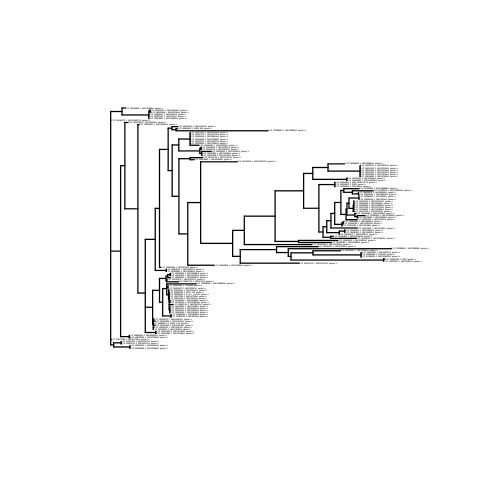

In [103]:
plot(pdu_region_tree, cex = 0.1)

In [101]:
tree = pdu_region_tree
tree <- as(tree, 'TreeMan')
nids <- tree['nds']

ERROR: Error in as.double(y): cannot coerce type 'S4' to vector of type 'double'


In [ ]:
res <- getNdsKids(tree, ids=nids)
# add children for each tip, which is just the tip, for consistency
res[tree['tips']] <- tree['tips']
print(res)

# [21.09] Нарисуем гистограмму значений метрик для разных деревьев (R)

In [5]:
library("phangorn")

Loading required package: ape


In [53]:
pdu_core_tree <- read.tree("studio/pdu/core_pdu_aligned.fasta.raxml.bestTreeCollapsed")
pdu_region_tree <- read.tree("studio/pdu/pdu.fasta.raxml.bestTreeCollapsed")

In [54]:
list_tree_files = list.files("tree_to_compare//pdu/trees/", "*.bestTreeCollapsed$",full.names = T)
list_tree = lapply(list_tree_files, read.tree)

In [58]:
??treedist

R Information

Help files with alias or concept or title matching ‘treedist’ using
fuzzy matching:


phangorn::treedist      Distances between trees
  Aliases: treedist
phytools::averageTree   Compute an average tree from a set of trees and
                        related operations
  Aliases: minTreeDist


Type '?PKG::FOO' to inspect entries 'PKG::FOO', or 'TYPE?PKG::FOO' for
entries like 'PKG::FOO-TYPE'.




In [69]:
treedist = function(tree1, tree2){
    tree1 = multi2di(tree1, random = TRUE)
    tree2 = multi2di(tree2, random = TRUE)
    dist = RF.dist(tree1, tree2, normalize = TRUE)
    return(dist)
}

In [70]:
RF_vals = sapply(list_tree, function(x){return(treedist(pdu_core_tree, x))})
pdu_wRF = treedist(pdu_core_tree, pdu_region_tree)
pdu_wRF

[1] 0.6052632

In [64]:
RF_vals = sapply(list_tree, function(x){return(path.dist(pdu_core_tree, x,use.weight = T))})
pdu_wRF = path.dist(pdu_core_tree, pdu_region_tree,use.weight = T)
pdu_wRF

[1] 1.372837

In [43]:
list_len = read.delim("tree_to_compare/pdu/list_length.tsv", head = F)
list_len[0:3,]

V1,V2
0,5
1,8
2,4


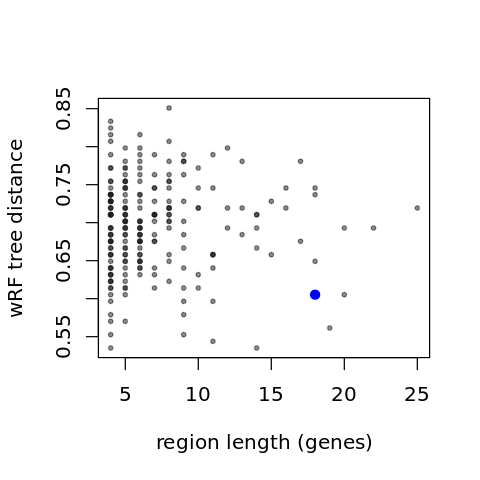

In [72]:
plot(list_len[,2],RF_vals, pch=19, col = rgb(0.1,0.1,0.1,0.5), cex = 0.5, xlab = "region length (genes)", ylab = "wRF tree distance")
points(18, pdu_wRF, col = "blue", pch=19)

In [21]:
cor.test(list_len[,2],RF_vals)


	Pearson's product-moment correlation

data:  list_len[, 2] and RF_vals
t = -0.49025, df = 222, p-value = 0.6244
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.16326462  0.09862237
sample estimates:
        cor 
-0.03288559 


# [21.09] Посчитаем деревья для кор-регионов подрядидущих ортогрупп

In [1]:
import pandas as pd

In [3]:
og = pd.read_csv("orthosnake/pdu/Results/Orthogroups.tsv", sep="\t", header = None)

In [4]:
core_og_pd =  pd.read_csv("orthosnake/pdu/Results/Orthogroups_SingleCopyOrthologues.txt", header = None)
core_og = core_og_pd[0].to_list()

In [5]:
core_og_pd = og[og[0].isin(core_og)]
core_og_in_genome = core_og_pd[1]
og_by_cds = dict(zip(core_og_in_genome, core_og_pd[0]))

#core_og_in_genome[0:3]

In [6]:
ids = [int(cds.split("|")[1]) for cds in core_og_in_genome]
og_by_id = {int(cds.split("|")[1]):og_by_cds[cds] for cds in core_og_in_genome}


возьмем подряд идущие ОГ-ки (согласно первому попавшемуся штамму). Длину серии возьмем минимум 5

In [8]:
from itertools import groupby
from operator import itemgetter
og_core_sets = []
for k, g in groupby(enumerate(ids), lambda ix : ix[0] - ix[1]):
    ids_seq = list(map(itemgetter(1), g))
    if(len(ids_seq) < 4): 
        continue
    og_core_sets.append([og_by_id[x] for x in ids_seq])
og_core_sets[0:3]

[['OG0000875', 'OG0000876', 'OG0000877', 'OG0000878', 'OG0000879'],
 ['OG0000885',
  'OG0000886',
  'OG0000887',
  'OG0000888',
  'OG0000889',
  'OG0000890',
  'OG0000891',
  'OG0000892'],
 ['OG0000893', 'OG0000894', 'OG0000895', 'OG0000896']]

### write to files

In [70]:
!mkdir -p tree_to_compare/
!mkdir -p tree_to_compare/pdu
!mkdir -p tree_to_compare/pdu/og_lists/`

In [71]:
i = 0
for og_core_set in og_core_sets:
    fname = "tree_to_compare/pdu/og_lists/{}".format(i)
    i = i + 1
    with open(fname, 'w') as filehandle:
        for x in og_core_set:
            filehandle.write('%s\n' % x)


In [14]:
i = 0
with open("tree_to_compare/pdu/list_length.tsv", 'w') as filehandle:
    [filehandle.write("{}\t{}\n".format(i, len(x))) for i,x in enumerate(og_core_sets)]
    

## [16.09]

### найдем опероны для какого-нибудь штамма (ЛФ82?)

In [4]:
grep "LF82" genomes_with_regions/pdu/*

genomes_with_regions/pdu/GCF_000284495.1_ASM28449v1_genomic.fna:>NC_011993.1 Escherichia coli LF82, complete genome


In [ ]:
ls /data11/bio/runs-manolov/from_7a/runs-manolov/ecoli_crohn/analyse/
